## Visualize All Deep Pretrained Classification model-metrics 

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from torch.optim import Adam
from transformers import AutoTokenizer, GPT2Tokenizer 
from transformers import GPT2Model, BartForSequenceClassification,\
                         RobertaForSequenceClassification,\
                         DistilBertForSequenceClassification 

from model_pipeline import *

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


import gc
import spacy
from spacy import displacy

import plotly.express as px

import random

## Load Combined Data

In [2]:
df = pd.read_csv('../../../Sample_Data/For_Modeling/sarealfakenews_dataset/Combined_Data.csv')
df.head()

,title,text,url,medium,label
0,Tsietsi Mashinini speaks on Soweto uprising,Image: Tsietsi Mashinini \nBy BO Staff Writer\...,https://blackopinion.co.za/category/intnews/fe...,blackopinion,fake
1,Parliament's tourism committee to question Tot...,The National Assembly's Portfolio Committee on...,https://www.news24.com/news24/politics/parliam...,news24,real
2,VIDEO: ANC Are Punch Drunk on Emergency Powers...,Local KDM traffic officers in KZN are punch dr...,https://sa-news.com/video-anc-are-punch-drunk-...,sa-news,fake
3,This is why Mpumalanga is repurposing some TB ...,The Mpumalanga health department plans to repu...,https://www.news24.com/news24/health/spotlight...,news24,real
4,Ramaphosa Cares More For Vicious Farm Attacker...,Ramaphosa told Bloomberg News in New York in 2...,https://sa-news.com/ramaphosa-cares-more-for-v...,sa-news,fake


In [3]:
df.label.unique()

array(['fake', 'real'], dtype=object)

Text(0.5, 1.0, 'Distribution of News Labels')

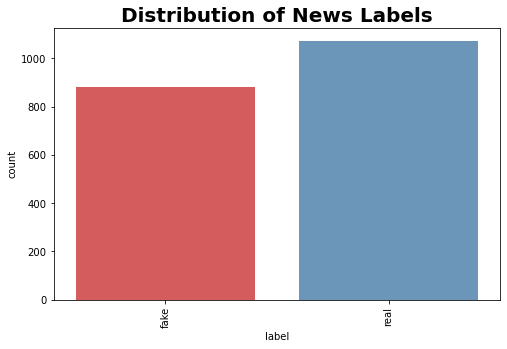

In [4]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.xticks(rotation=90)
plt.title('Distribution of News Labels',fontsize=20, fontweight='bold')

## Split training-test dataset
* One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [5]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1564 196 196


## Preprocessing data (text tokenization)

In [6]:
labels = {"real": 0,"fake": 1}

In [7]:
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [8]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.padding_side = "left"
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [10]:
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

# Model building



In [11]:
EPOCHS = 1
LR = 1e-5

In [12]:
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [18]:
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [14]:
gpt2_model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=512, gpt_model_name="gpt2")

In [15]:
bart_model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=2)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training loop
* Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). <br> 

In [16]:
train(distilbert_model, 'distilbert', df_train, df_val, labels, distilbert_tokenizer, LR, EPOCHS)

100%|██████████| 782/782 [01:16<00:00, 10.21it/s]


Epochs: 1 | Train Loss:  0.124             | Train Accuracy:  0.899             | Val Loss:  0.080             | Val Accuracy:  0.939


In [19]:
train(roberta_model, 'roberta', df_train, df_val, labels, roberta_tokenizer, LR, EPOCHS)

100%|██████████| 782/782 [02:32<00:00,  5.12it/s]


Epochs: 1 | Train Loss:  0.046             | Train Accuracy:  0.966             | Val Loss:  0.096             | Val Accuracy:  0.929


In [25]:
train(gpt2_model, 'gpt2', df_train, df_val, labels, gpt2_tokenizer, LR, EPOCHS)

  0%|          | 1/782 [00:00<04:15,  3.05it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ /home/siyanda/Documents/Projects/Text                                                            │
│ Analysis/text_analysis/Code/Modeling/safakenews/model_pipeline.py:69 in train                    │
│                                                                                                  │
│    66 │   │   │   model.zero_grad()                                                              │
│    67 │   │   │                                                                                  │
│    68 │   │   │   if model_name =='gpt2':                                                        │
│ ❱  69 │   │   │   │   output = model(input_id, mask)                                             │
│    70 │   │   │   else:                                                                          │
│    71 │   │   │   │   output = model(input_id, mask, labels=train_label)                         │
│    72                                                                                            │
│                                                                                                  │
│ /home/siyanda/anaconda3/envs/NLP/lib/python3.9/site-packages/torch/nn/modules/module.py:1194 in  │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.                                           │
│   1192 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1193 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1194 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1195 │   │   # Do not call functions when jit is used                                          │
│   1196 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1197 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /home/siyanda/Documents/Projects/Text                                                            │
│ Analysis/text_analysis/Code/Modeling/safakenews/model_pipeline.py:185 in forward                 │
│                                                                                                  │
│   182 │   │   Args:                                                                              │
│   183 │   │   │   │   input_id: encoded inputs ids of sent.                                      │
│   184 │   │   """                                                                                │
│ ❱ 185 │   │   gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict   │
│   186 │   │   batch_size = gpt_out.shape[0]                                                      │
│   187 │   │   linear_output = self.fc1(gpt_out.view(batch_size,-1))                              │
│   188 │   │   return linear_output                                                               │
│                                                                                                  │
│ /home/siyanda/anaconda3/envs/NLP/lib/python3.9/site-packages/torch/nn/modules/module.py:1194 in  │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.     

In [ ]:
train(bart_model, 'bart', df_train, df_val,labels, bart_tokenizer, LR, EPOCHS)

* Looks like the model is already well trained after 1 epoch! <br>
  This is probably due to the fact that as a pre-trained model with gigantic number of parameters, <br>
 

# Evaluation
* After model training, it's recommended to use the test data to evaluate the model<br>
  performance on unseen data. I build the evaluate function according this PyTorch guide.

In [ ]:
true_labels, pred_labels = evaluate(model, model_name, df_test,labels, tokenizer)

* Another good gauge of model performance is the confusion matrix.

In [ ]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
ax.set_title("BART SA Fake News Classifier Confusion Matrix")
disp.plot(ax=ax)
plt.savefig('bart.png', format="png", dpi=300, transparent=True)

In [ ]:
print(f"BART Accuracy Score: {accuracy_score(y_true=true_labels, y_pred=pred_labels)*100:.2f}%")